# Parte 1

## Importar datos

In [1]:
import yfinance as yf
from datetime import datetime, timedelta

In [2]:
def importar_datos(ticker):
  end_date = datetime(2024, 7, 1)
  start_date = datetime(2023, 7, 1)
  data = yf.download(ticker, start=start_date, end=end_date)
  return data

In [3]:
data = importar_datos("AAPL")

[*********************100%%**********************]  1 of 1 completed


In [4]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-07-03,193.779999,193.880005,191.759995,192.460007,191.221970,31458200
2023-07-05,191.570007,192.979996,190.619995,191.330002,190.099228,46920300
2023-07-06,189.839996,192.020004,189.199997,191.809998,190.576126,45094300
2023-07-07,191.410004,192.669998,190.240005,190.679993,189.453384,46778000
2023-07-10,189.259995,189.990005,187.039993,188.610001,187.396729,59922200


<Axes: xlabel='Date'>

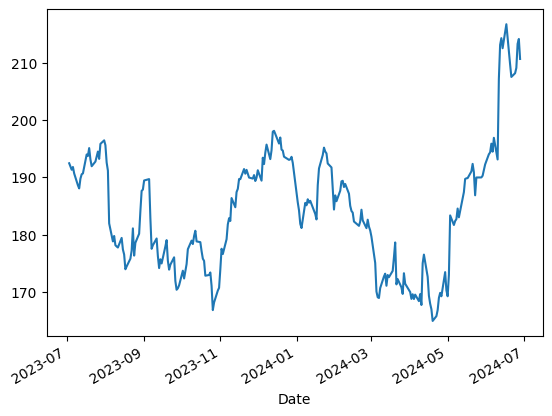

In [5]:
data["Close"].plot()

## Calcular rendimientos

In [6]:
rendimientos = data["Close"].pct_change().dropna()

<Axes: xlabel='Date'>

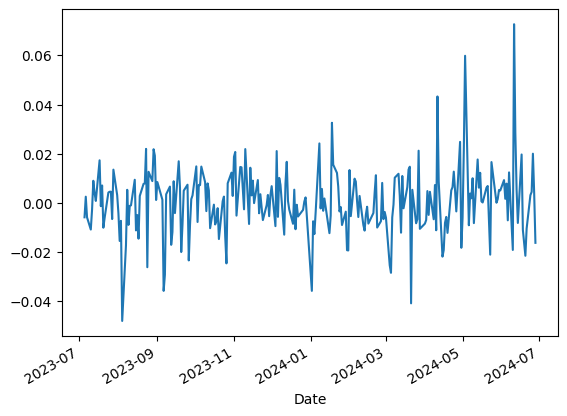

In [7]:
rendimientos.plot()

## Rendimiento anualizado
Convierte el rendimiento de un período a su equivalente anual. Recibe un pd.Series o un pd.DataFrame

In [8]:
def rendimiento_anualizado(rendimientos, p=252):
  # número de periodos
  n_periods = rendimientos.shape[0]

  # rendimiento equivalente del periodo
  rendimiento_periodo = (rendimientos+1).prod()**(1/n_periods) - 1

  # rendimiento anualizado equivalente
  rendimiento_anual = (1+rendimiento_periodo)**p-1
  return rendimiento_anual

NOTA 1: Hay que tomar en cuenta que "p" y el "numero de periodos" no son lo mismo.
La funcion va a recibir varios datos. La "p" indica la periodicidad de dichos datos, si son datos mensuales entonces p=12, si son bimestrales, p=6,... Si son diarios p=252...
Sin embargo esto no tiene que coincidir con el numero de periodos. Por ejemplo, puedo estar usando rendimientos diarios (p=252) pero solo darle 4 registros a la funcion. Lo mismo con lo demas, puedo usar datos mensuales (p=12) pero solo darle informacion de 5 meses.
La funcion usa los registros para hallar el equivalente del periodo (diario, mensual, bimestral, etc) y luego utiliza la p para convertir dicho valor al anualizado.

NOTA 2: En algunas ocasiones el rendimiento_periodo (para el caso diario) suele tomarse únicamente el promedio de los rendimientos, es importante darse cuenta que el valor que estamos obteniendo en nuestra fórmula es diferente a calcular el promedio (recordar equivalencias de matemáticas financieras). El rendimiento que obtenemos nosotros es el rendimiento diario equivalente.
$$(1+r_1)(1+r_2)=(1+r_p)^2$$
$$[(1+r_1)(1+r_2)]^{1/2}-1=r_p$$

Lo cual es diferente a
$$ \frac{r_1+r_2}{2} = r_p $$

In [9]:
rendimiento_anualizado(rendimientos)

0.09554670794086939

## Volatilidad anualizada

In [10]:
def volatilidad_anualizada(rendimientos, p=252):
  volatilidad = rendimientos.std()
  volatilidad_anualizada = volatilidad*p**(1/2)
  return volatilidad_anualizada

In [11]:
volatilidad_anualizada(rendimientos)

0.21903169607152928

## Return-Risk Ratio

In [12]:
def return_risk_ratio(rendimientos):
  return rendimiento_anualizado(rendimientos)/volatilidad_anualizada(rendimientos)

In [13]:
return_risk_ratio(rendimientos)

0.43622320264399844

## Sharpe Ratio

In [14]:
def sharpe_ratio(rendimientos, risk_free_rate=0.0):
  exceso = rendimiento_anualizado(rendimientos) - risk_free_rate
  volatilidad = volatilidad_anualizada(rendimientos)
  return exceso/volatilidad

In [15]:
sharpe_ratio(rendimientos, risk_free_rate=0.10)

-0.020331724307500687

## Max Drawdowns

In [16]:
import pandas as pd
def drawdown(return_series: pd.Series):
    """Takes a time series of asset returns.
       returns a DataFrame with columns for
       the wealth index,
       the previous peaks, and
       the percentage drawdown
    """
    wealth_index = 1000*(1+return_series).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks
    return pd.DataFrame({"Wealth": wealth_index,
                         "Previous Peak": previous_peaks,
                         "Drawdown": drawdowns})

In [17]:
ddown = drawdown(rendimientos)
ddown.head(20)

,Wealth,Previous Peak,Drawdown
Date,,,
2023-07-05,994.128625,994.128625,0.000000
2023-07-06,996.622627,996.622627,0.000000
2023-07-07,990.751252,996.622627,-0.005891
2023-07-10,979.995812,996.622627,-0.016683
2023-07-11,977.242000,996.622627,-0.019446
2023-07-12,986.023058,996.622627,-0.010635
2023-07-13,990.023832,996.622627,-0.006621
2023-07-14,990.803262,996.622627,-0.005839
2023-07-17,1007.949697,1007.949697,0.000000


<Axes: xlabel='Date'>

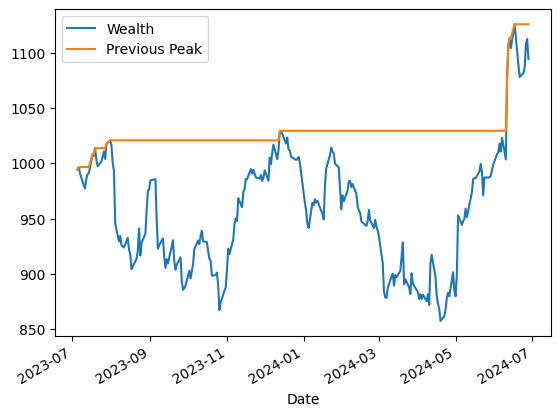

In [18]:
ddown[["Wealth", "Previous Peak"]].plot()

<Axes: xlabel='Date'>

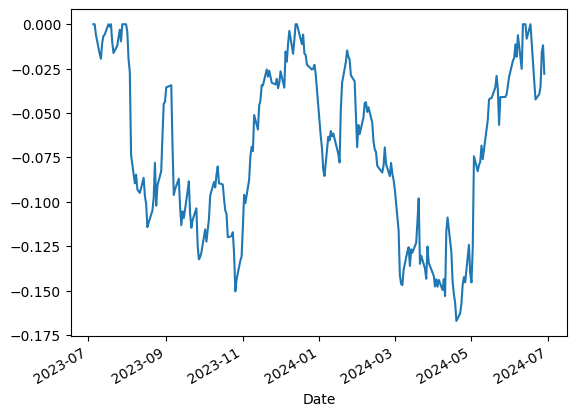

In [19]:
ddown["Drawdown"].plot()

In [20]:
def max_drawdown(r):
  return drawdown(r)["Drawdown"].min()

In [21]:
minimo = ddown["Drawdown"].min()
fecha_minimo = ddown["Drawdown"].idxmin()
print(f"Mínimo: {minimo:.2f}, Fecha: {fecha_minimo}")

Mínimo: -0.17, Fecha: 2024-04-19 00:00:00


# Parte 2

## Sesgo

In [22]:
# Usando función ya existente de la librería stats
import scipy.stats as stats

In [23]:
sesgo_poblacional = stats.skew(rendimientos)
print(f"Sesgo poblacional: {sesgo_poblacional}")

Sesgo poblacional: 0.568948351901472


In [24]:
sesgo_muestral = stats.skew(rendimientos, bias=False)
print(f"Sesgo muestral: {sesgo_muestral}")

Sesgo muestral: 0.5724023451655961


## Curtosis

In [25]:
# Se compara con 0 (ya nos da el exceso de curtosis)

# Curtosis poblacional
curtosis = stats.kurtosis(rendimientos)
curtosis

4.359270120101349

In [26]:
# Curtosis muestral
curtosis = stats.kurtosis(rendimientos, bias=False)
curtosis

4.47257739123603

In [27]:
# Si lo calculamos manual (formula de las diapositivas) se compara con 3
def kurtosis(r):
    """
    Alternative to scipy.stats.kurtosis()
    Computes the kurtosis of the supplied Series or DataFrame
    Returns a float or a Series
    """
    demeaned_r = r - r.mean()
    # use the population standard deviation, so set dof=0
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**4).mean()
    return (exp/sigma_r**4)

kurtosis(rendimientos)

7.359270120101348

## Prueba Jarque-Bera

In [28]:
# La hipotesis nula es que se trata de una distribución normal
def prueba_jarque_bera(rendimientos, alpha=0.05):
  x, p_value = stats.jarque_bera(rendimientos)
  print(f"Estadístico: {x:.3f}")
  print(f"P-value: {p_value}")
  if p_value < alpha:
    print(f"Con un nivel de significancia del {alpha*100}% se rechaza la hipótesis nula")
    print("Los rendimientos no siguen una distribución normal")
  else:
    print(f"Con un nivel de significancia del {alpha*100}%")
    print("no existe evidencia suficiente para rechazar que los rendimientos siguen una distribución normal")

In [29]:
prueba_jarque_bera(rendimientos, 0.01)

Estadístico: 210.592
P-value: 1.864152299108137e-46
Con un nivel de significancia del 1.0% se rechaza la hipótesis nula
Los rendimientos no siguen una distribución normal


Recordar cómo funciona la **prueba de hipótesis** (inferencia estadística):

Si suponemos que la hipótesis nula se cumple, **¿cuál es la probabilidad de que suceda la observación actual?**

*   Si dicha probabilidad es menor a nuestro nivel de significancia "**α**" entonces "*con un nivel de significancia del 100α% se rechaza la hipótesis nula*"
*   En caso de que "**p**" sea mayor a "**α**" eso no significa que se acepte la hipótesis nula, simplemente "*con un nivel de significancia del 100α% no hay evidencia suficiente para rechazarla*". >> ES INOCENTE HASTA QUE SE DEMUESTRE LO CONTRARIO

## Semivolatilidad

In [30]:
import pandas as pd
import numpy as np

def semideviation(r, objetivo=False):
    """
    Returns the semideviation aka negative semideviation of r
    r must be a Series or a DataFrame
    """
    if objetivo is False:
        # No hay objetivo, se elige la media
        objetivo = r.mean()

    # Calcular las desviaciones negativas
    deviations = r[r < objetivo] - objetivo
    squared_deviations = deviations**2

    # Calcular la semidesviación
    semidev = np.sqrt(squared_deviations.mean())
    return semidev

In [31]:
semideviation(rendimientos) # si no ponemos un valor objetivo elegirá la media

0.013515849565683597

In [32]:
semideviation(rendimientos, 0) # igual podemos estar interesados en cómo se comporta debajo del cero

0.013277421977899453

## VaR "Value at Risk"

### VaR Histórico

In [33]:
import numpy as np

In [34]:
def var_historic(r, level=5):
    """
    Returns the historic Value at Risk at a specified level
    i.e. returns the number such that "level" percent of the returns
    fall below that number, and the (100-level) percent are above
    """
    if isinstance(r, pd.DataFrame):
        return r.aggregate(var_historic, level=level)

    elif isinstance(r, pd.Series):
        return -np.percentile(r, level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")

In [35]:
var_historic(rendimientos, level=5) #Devuelve el VaR histórico 95%

0.020631729743843995

### VaR Gaussiano

In [36]:
from scipy.stats import norm
def var_gaussian(r, level=5, modified=False):
    """
    Returns the Parametric Gauusian VaR of a Series or DataFrame
    If "modified" is True, then the modified VaR is returned,
    using the Cornish-Fisher modification
    """
    # compute the Z score assuming it was Gaussian
    z = norm.ppf(level/100)
    if modified:
        # modify the Z score based on observed skewness and kurtosis
        s = stats.skew(r)
        k = kurtosis(r) # usamos la curtosis que definimos para comparar con 3
        z = (z +
                (z**2 - 1)*s/6 +
                (z**3 -3*z)*(k-3)/24 -
                (2*z**3 - 5*z)*(s**2)/36
            )
    return -(r.mean() + z*r.std(ddof=0))

In [37]:
var_gaussian(rendimientos) # VaR Gaussiano 95% (predeterminado)

0.022193067647380497

In [38]:
var_gaussian(rendimientos, modified=True) # VaR Cornish-Fisher 95%

0.01867097171152958

## CVaR "Conditional Value at Risk"

In [39]:
def cvar_historic(r, level=5):
    """
    Computes the Conditional VaR of Series or DataFrame
    """
    if isinstance(r, pd.Series):
        is_beyond = r <= -var_historic(r, level=level)
        return -r[is_beyond].mean()
    elif isinstance(r, pd.DataFrame):
        return r.aggregate(cvar_historic, level=level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")

In [40]:
cvar_historic(rendimientos) # CVaR al 95%, es el valor promedio en el peor 5% de nuestros datos

0.02939522791306197

## Summary (Opcional)

De todo lo que hemos visto hasta ahora, qué cosas podemos combinar para automatizar un análisis preliminar de varias acciones e irlas filtrando acorde a criterios que definamos?

Tal vez definir una función que utilice todas las funciones anteriores y nos otorgue un resumen bien sintetizado de una o varias acciones

Por ejemplo, crear una función que reciba una lista de tickers y calcule los indicadores más importantes para todos ellos y los vaya acomodando en serie.

Al final voy a tener un dataframe cuyas columnas serán diferentes acciones y cuyas filas serán los indicadores anteriores. Esto nos permitirá elegir a qué acciones convendrá hacerles los análisis que haremos posteriormente.

In [41]:
def summary(tickers):
  datos = {
    "rend_anual":[],
    "vol_anual":[],
    "sharpe":[],
    "rr_ratio":[],
    "max_ddown":[],
    "sesgo":[],
    "curtosis":[],
    "jarque_bera":[],
    "semidev":[],
    "var_hist":[],
    "var_gauss":[],
    "cvar_hist":[]
  }
  for ticker in tickers:
    data = importar_datos(ticker)
    rendimientos = data["Close"].pct_change().dropna()
    datos["rend_anual"].append(rendimiento_anualizado(rendimientos))
    datos["vol_anual"].append(volatilidad_anualizada(rendimientos))
    datos["sharpe"].append(sharpe_ratio(rendimientos))
    datos["rr_ratio"].append(return_risk_ratio(rendimientos))
    datos["max_ddown"].append(max_drawdown(rendimientos))
    datos["sesgo"].append(stats.skew(rendimientos))
    datos["curtosis"].append(stats.kurtosis(rendimientos))
    datos["jarque_bera"].append(stats.jarque_bera(rendimientos)[1])
    datos["semidev"].append(semideviation(rendimientos))
    datos["var_hist"].append(var_historic(rendimientos))
    datos["var_gauss"].append(var_gaussian(rendimientos))
    datos["cvar_hist"].append(cvar_historic(rendimientos))
  df = pd.DataFrame(datos, index=tickers)
  return df

Podemos modificar algunas cosas en la tabla anterior. Por ejemplo: el sharpe ratio que utilice un tasa libre de riesgo diferente de 0, los niveles para calcular el VaR, si queremos el VaR Cornish Fisher, si las periodicidades son diferentes a las predeterminadas.
Así podemos hacer varias modificaciones para tener un resultado más personalizado.

In [42]:
tickers = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA', 'NFLX', 'META', 'NVDA', 'JPM', 'V']

df_resumen = summary(tickers).sort_values("rend_anual", ascending=False)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [43]:
df_resumen

,rend_anual,vol_anual,sharpe,rr_ratio,max_ddown,sesgo,curtosis,jarque_bera,semidev,var_hist,var_gauss,cvar_hist
NVDA,1.950548,0.452224,4.313233,4.313233,-0.197912,0.719579,4.061360,1.489415e-42,0.026238,0.036594,0.042063,0.049458
META,0.774967,0.359046,2.158406,2.158406,-0.184264,2.318186,25.178808,0.000000e+00,0.019911,0.025800,0.034602,0.040425
NFLX,0.536654,0.347687,1.543498,1.543498,-0.275131,1.403116,13.653594,0.000000e+00,0.019934,0.025100,0.034013,0.042197
GOOGL,0.526856,0.278502,1.891751,1.891751,-0.144030,-0.106287,8.585324,6.945949e-167,0.018839,0.021651,0.026965,0.036992
AMZN,0.491102,0.279114,1.759504,1.759504,-0.174525,0.658116,3.285910,5.914013e-29,0.016212,0.024783,0.027123,0.033500
JPM,0.384937,0.170793,2.253820,2.253820,-0.141203,-1.348156,6.305436,1.119684e-106,0.012177,0.013390,0.016310,0.024965
MSFT,0.326836,0.201271,1.623858,1.623858,-0.131714,-0.354307,0.479569,2.241842e-02,0.013477,0.022138,0.019610,0.028398
V,0.104257,0.136361,0.764566,0.764566,-0.096084,-0.404981,0.316468,1.978684e-02,0.009635,0.013986,0.013670,0.019005
AAPL,0.095547,0.219032,0.436223,0.436223,-0.167129,0.568948,4.359270,1.864152e-46,0.013516,0.020632,0.022193,0.029395
TSLA,-0.295777,0.499263,-0.592427,-0.592427,-0.515750,0.587502,3.691173,1.564251e-34,0.029166,0.041863,0.052530,0.064025


In [44]:
# Descargar en archivo CSV
write_csv = df_resumen.to_csv("resumen.csv")

## Examen de la unidad I ##

In [45]:
start_date = datetime(2023, 9, 1)
end_date = datetime(2024, 9, 1)

ticker1 = 'GOOGL'
ticker2 = 'MSFT'

datos_1 = yf.download(ticker1, start=start_date, end=end_date)
datos_2 = yf.download(ticker2, start=start_date, end=end_date)

rend_1 = datos_1['Adj Close'].pct_change().dropna()
rend_2 = datos_2['Adj Close'].pct_change().dropna()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [46]:
print(f' Rendimiento anualizado de Google: {rendimiento_anualizado(rend_1)}')
print(f' Rendimiento anualizado de Microsoft: {rendimiento_anualizado(rend_2)}')

 Rendimiento anualizado de Google: 0.2075223779786337
 Rendimiento anualizado de Microsoft: 0.2812589265138308


In [47]:
print(f' Rendimiento anualizado de Google: {volatilidad_anualizada(rend_1)}')
print(f' Rendimiento anualizado de Microsoft: {volatilidad_anualizada(rend_2)}')

 Rendimiento anualizado de Google: 0.27766465627259
 Rendimiento anualizado de Microsoft: 0.19909645355036606


In [48]:
print(f' RR de google {return_risk_ratio(rend_1)}')
print(f' RR de microsoft {return_risk_ratio(rend_2)}')

 RR de google 0.7473849238302193
 RR de microsoft 1.4126767277784775


In [49]:
print(f' Sharpe ratio de google {sharpe_ratio(rend_1, risk_free_rate=0.09)}')

 Sharpe ratio de google 0.4232529251517672


In [50]:
print(f' El maxdrawdown de google es {max_drawdown(rend_1)}'

-0.1720367873325443

In [51]:
print(f"Sesgo poblacional de Google: {stats.skew(rend_1)}")
print(f"Sesgo poblacional de Microsoft: {stats.skew(rend_2)}")

Sesgo poblacional de Google: -0.3734431949052107
Sesgo poblacional de Microsoft: -0.49740835166808467


In [52]:
print(f"Curtosis poblacional de Google: {stats.kurtosis(rend_1)}")
print(f"Curtosis poblacional de Microsoft: {stats.kurtosis(rend_2)}")

Curtosis poblacional de Google: 8.528636703431822
Curtosis poblacional de Microsoft: 0.3509342977243346


In [53]:
prueba_jarque_bera(rend_1, 0.05)

Estadístico: 763.495
P-value: 1.6190128167650367e-166
Con un nivel de significancia del 5.0% se rechaza la hipótesis nula
Los rendimientos no siguen una distribución normal


In [54]:
prueba_jarque_bera(rend_2, 0.05)

Estadístico: 11.592
P-value: 0.00303995592108548
Con un nivel de significancia del 5.0% se rechaza la hipótesis nula
Los rendimientos no siguen una distribución normal


In [55]:
print(f' El rendimiento esperado en el peor 10% de los casos para google es {semideviation(rend_1, 0)}')

0.019432872049505525

In [56]:
var_historic(rend_2, level=5)

0.02333233294613815

In [57]:
var_gaussian(rend_1, modified=True) # VaR Cornish-Fisher 95%

0.0266140540047671

In [58]:
cvar_historic(rend_1,10)

0.09509402196156258

In [59]:
cvar_historic(rend_2,10)

0.03751430066025818

### Resultados con Ticker 'GOOG'

In [67]:
ticker3 = 'GOOG'
datos_3 = yf.download(ticker3, start=start_date, end=end_date)
rend_3 = datos_3['Adj Close'].pct_change().dropna()

print(f' Pregunta 6: RR de google {return_risk_ratio(rend_3)}')
print(f' Pregunta 7: Sharpe ratio de google {sharpe_ratio(rend_3, risk_free_rate=0.09)}')
print(f' Pregunta 8: El maxdrawdown de google es {-max_drawdown(rend_3)}')
print(f' Pregunta 16: El rendimiento esperado en el peor 10% de los casos para google es {cvar_historic(rend_3,10)}')

[*********************100%%**********************]  1 of 1 completed

 Pregunta 6: RR de google 0.7622330842302492
 Pregunta 7: Sharpe ratio de google 0.43579271125274993
 Pregunta 8: El maxdrawdown de google es 0.16671865100522437
 Pregunta 16: El rendimiento esperado en el peor 10% de los casos para google es 0.03130965115268302
